# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Имеются данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо построить прогноз на каждый месяц на два года вперёд.

In [2]:
wage = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


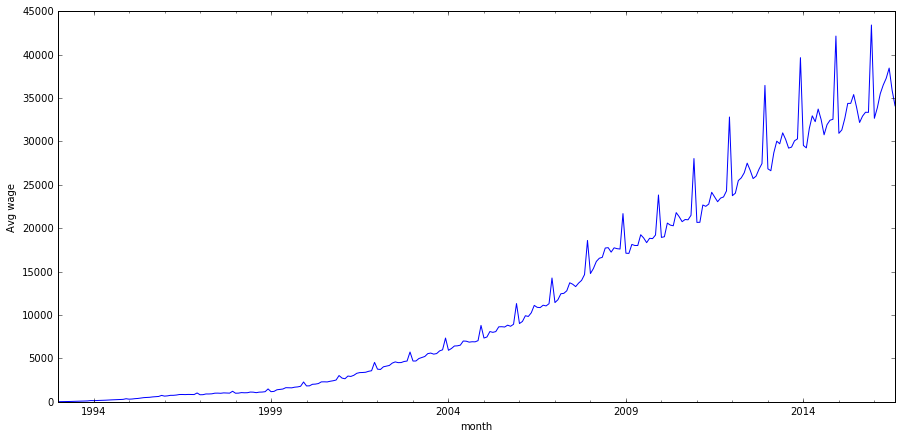

In [3]:
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('Avg wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


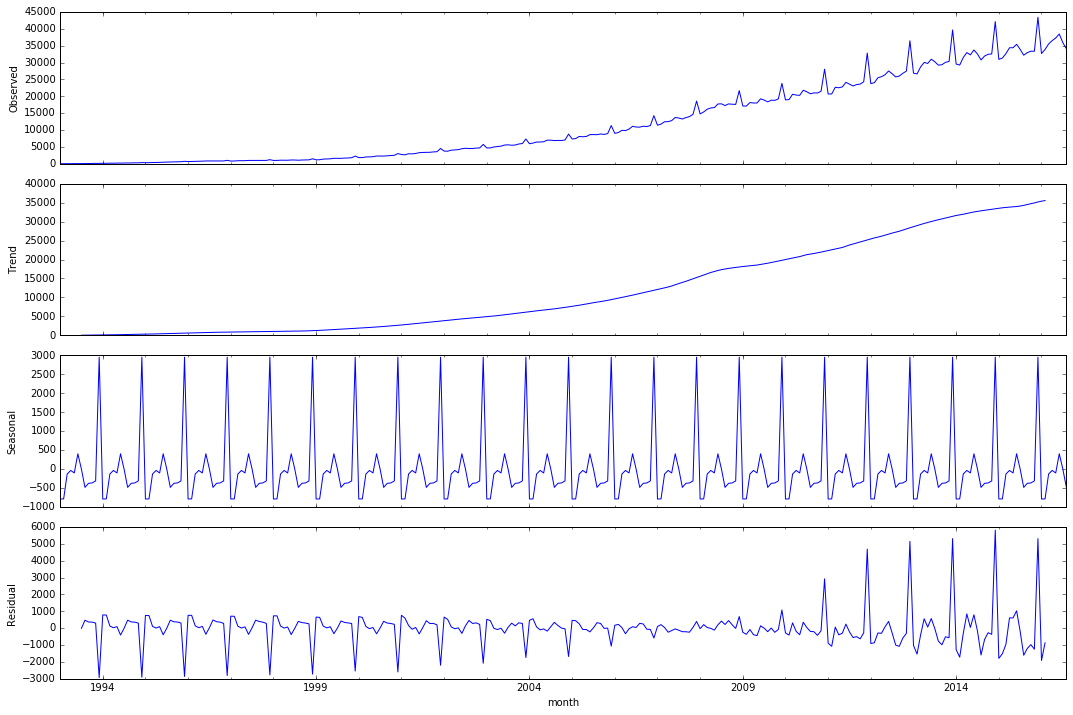

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


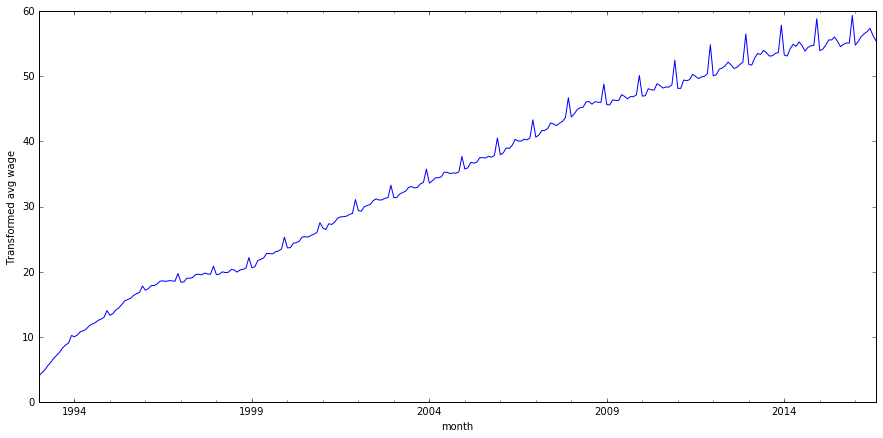

In [5]:
wage['wage_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.wage_box.plot()
plt.ylabel(u'Transformed avg wage')
print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box)[1]

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и визуально в данных виден тренд. 

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


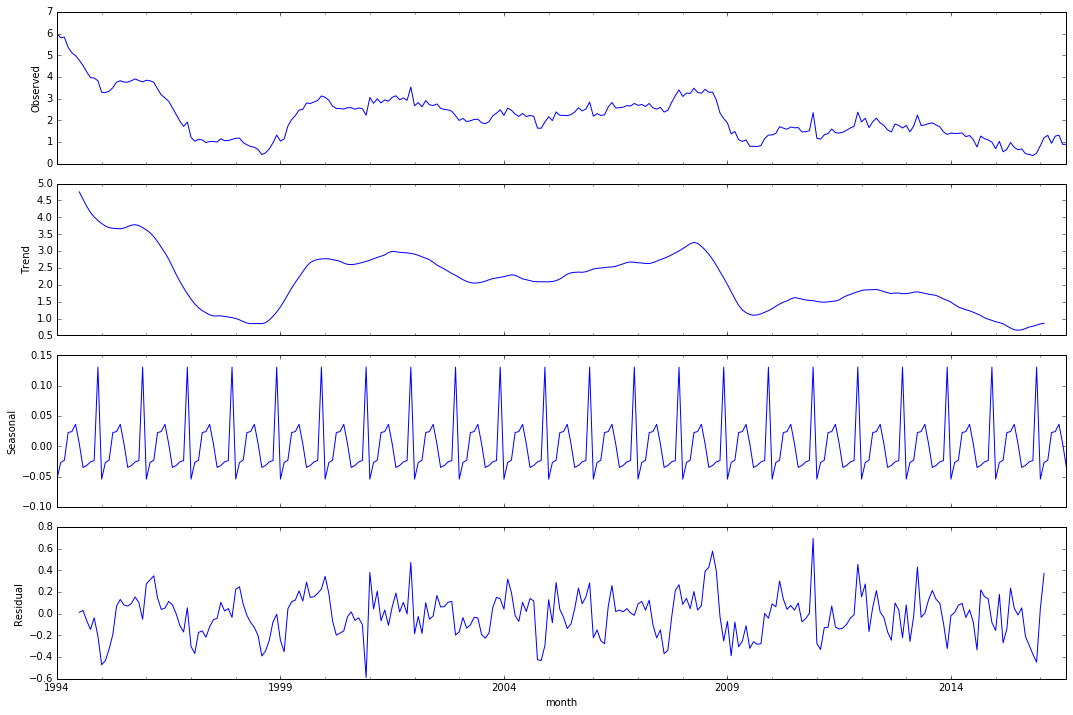

In [6]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff[12:])[1]

Не смотря на то, что гипотеза о нестационарности отвергается, визуально видно что в данных все еще присутствует тренд.

Применим еще обычное дифференцирование:

Критерий Дики-Фуллера: p=5.20360371582e-08


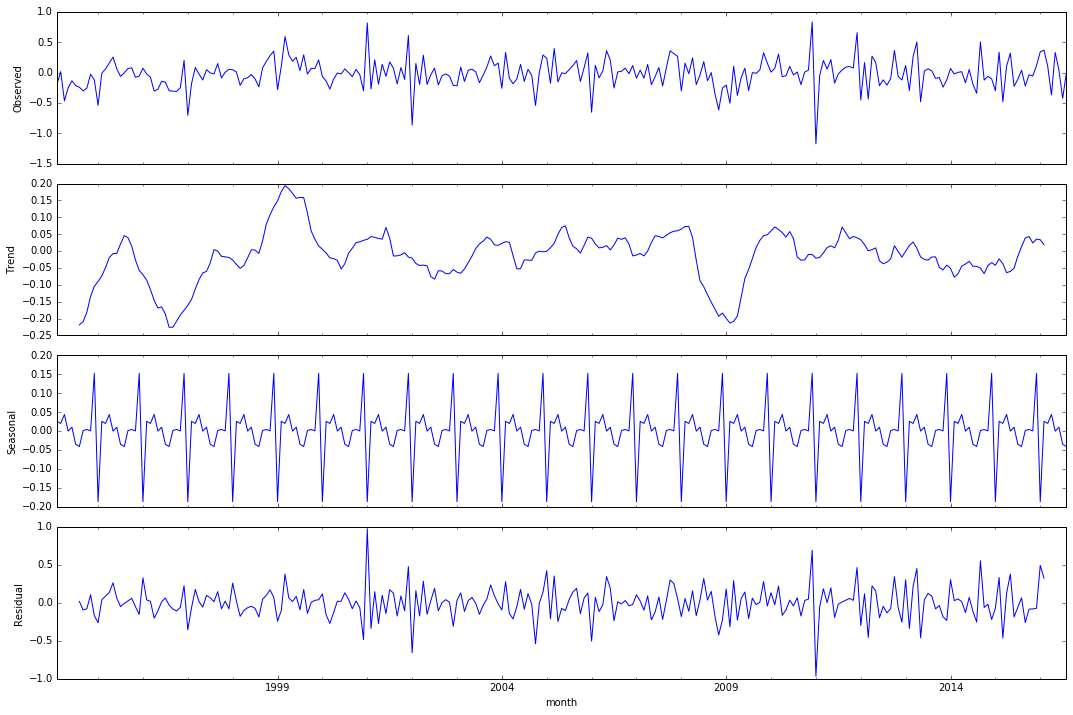

In [7]:
wage['wage_box_diff2'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wage_box_diff2[13:]).plot()   
print "Критерий Дики-Фуллера: p=%s" % sm.tsa.stattools.adfuller(wage.wage_box_diff2[13:])[1]

Гипотеза нестационарности отвергается, и нам удалось избавитсья от тренда. 

### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

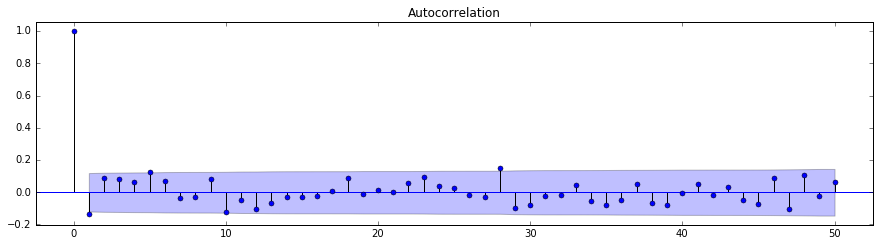

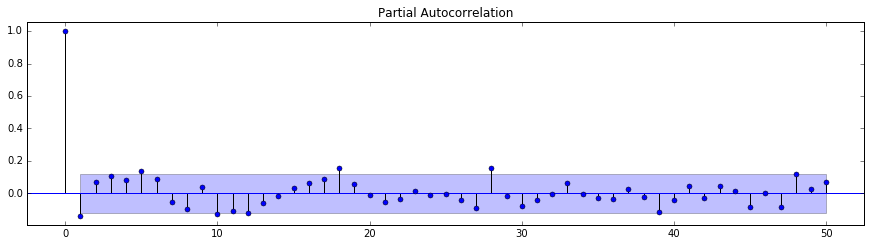

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=1, p=1

In [12]:
ps = range(0, 5)
d=1
qs = range(0, 5)
Ps = range(0, 4)
D=1
Qs = range(0, 3)

In [13]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

300

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 0, 2)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 1, 2)
wrong parameters: (1, 2, 2, 0)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (1, 2, 2, 2)
wrong parameters: (1, 2, 3, 0)
wrong parameters: (1, 2, 3, 1)
wrong parameters: (1, 2, 3, 2)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 0, 2)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 1, 2)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 1, 2, 2)
wrong parameters: (2, 1, 3, 0)
wrong parameters: (2, 1, 3, 1)
wrong parameters: (2, 1, 3, 2)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 0, 2)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (2, 2, 1, 2)
wrong parameters: (2, 2, 2, 0)
wrong pa

In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

       parameters        aic
91   (1, 3, 2, 2) -13.283452
103  (1, 4, 2, 2) -12.491744
98   (1, 4, 1, 0) -10.975837
86   (1, 3, 1, 0) -10.549779
96   (1, 4, 0, 1) -10.289103


Лучшая модель:

In [18]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 3)x(2, 1, 2, 12)   Log Likelihood                  15.642
Date:                            Wed, 05 Oct 2016   AIC                            -13.283
Time:                                    08:32:42   BIC                             19.557
Sample:                                01-01-1993   HQIC                            -0.117
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7753      0.125      6.210      0.000       0.531       1.020
ma.L1         -0.9888      0.132   

Её остатки:

Критерий Стьюдента: p=0.799764
Критерий Дики-Фуллера: p=0.000000


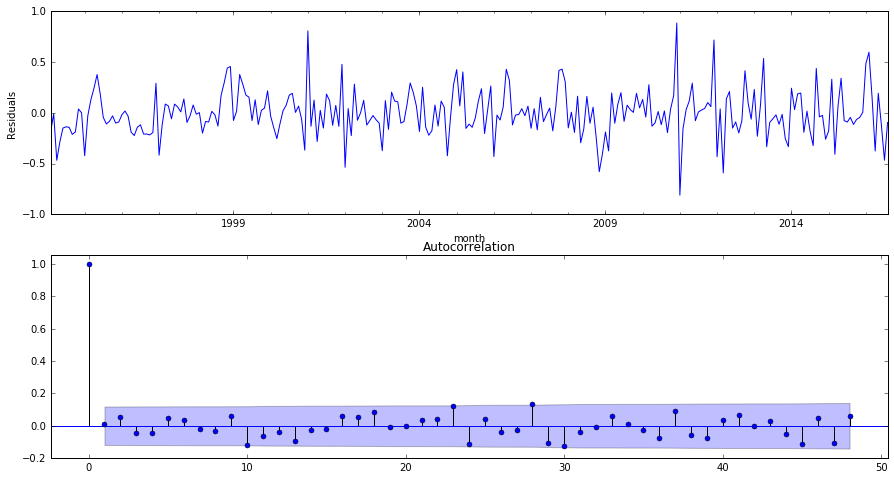

In [19]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

Опишем наши данные моделью:

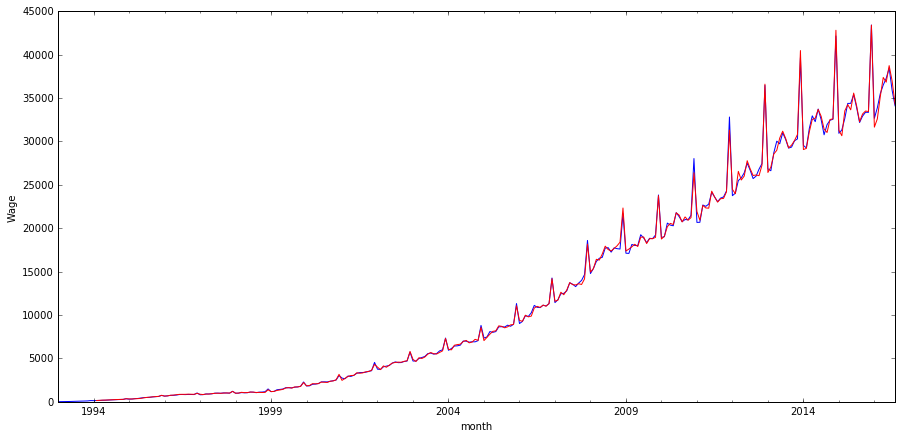

In [21]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогноз

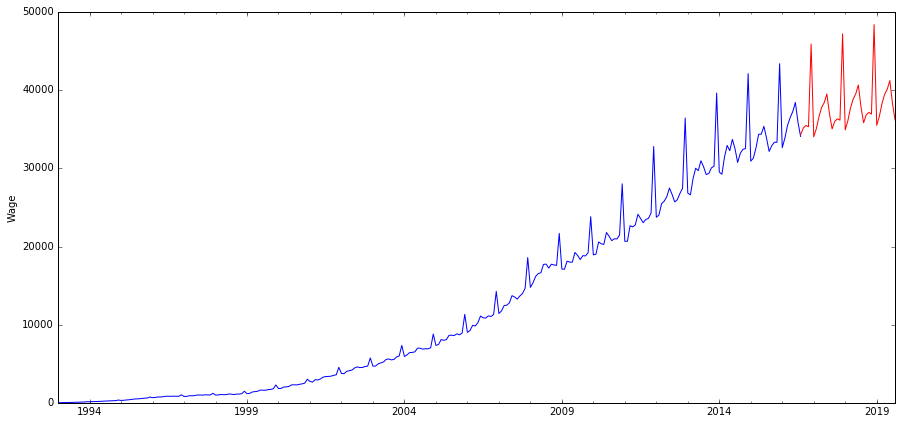

In [32]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=len(wage)-1, end=len(wage)+36), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()